In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')   # very important command setting the dimension 
# For 2D data (e.g. image), "tf" assumes (rows, cols, channels) 
#while "th" assumes (channels, rows, cols).
# The dimensionality has been set at 100 for consistency with other GAN implementations. 
# But 10 works better here
latent_dim = 100
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]
print(X_train.shape)
# Use Adam as the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)


Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
(60000, 1, 28, 28)


In [2]:

# Make our Generator Model
generator = Sequential()

# Transforms the input into a 7 × 7 128-channel feature map
generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

# Produces a 28 × 28 1-channel feature map (shape of a MNIST image)
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
print(generator.summary()) 
generator.compile(loss='binary_crossentropy', optimizer=adam)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [3]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [ ]:
# https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
#very important to read for GANS


In [4]:
discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [5]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1, 28, 28)         839937    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,052,802
Trainable params: 839,937
Non-trainable params: 212,865
_________________________________________________________________


In [6]:
discriminator.summary()   #IT Happened after we freezed discriminator weights 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [7]:
# Make our Discriminator Model
# Creating the Adversarial Network. We need to make the Discriminator weights
# non trainable. This only applies to the GAN model.


# Our Discriminator and Generator Losses
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
#def saveModels(epoch):
    #generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    #discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

## Train our GAN and Plot the Synthetic Image Outputs 

After each consecutive Epoch we can see how synthetic images being improved 

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 30
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:33, 14.07it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:32, 14.25it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:32, 14.33it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:44, 10.54it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:33, 14.04it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:32, 14.30it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:32, 14.23it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:32, 14.34it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:44, 10.57it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:33, 14.06it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:32, 14.52it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:32, 14.25it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:32, 14.19it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:45, 10.34it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:32, 14.25it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:32, 14.37it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:32, 14.29it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:32, 14.21it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:37, 12.29it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:32, 14.35it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:32, 14.39it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:32, 14.29it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:32, 14.27it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:32, 14.41it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:32, 14.17it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:32, 14.25it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:32, 14.29it/s]

--------------- Epoch 30 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.15it/s]


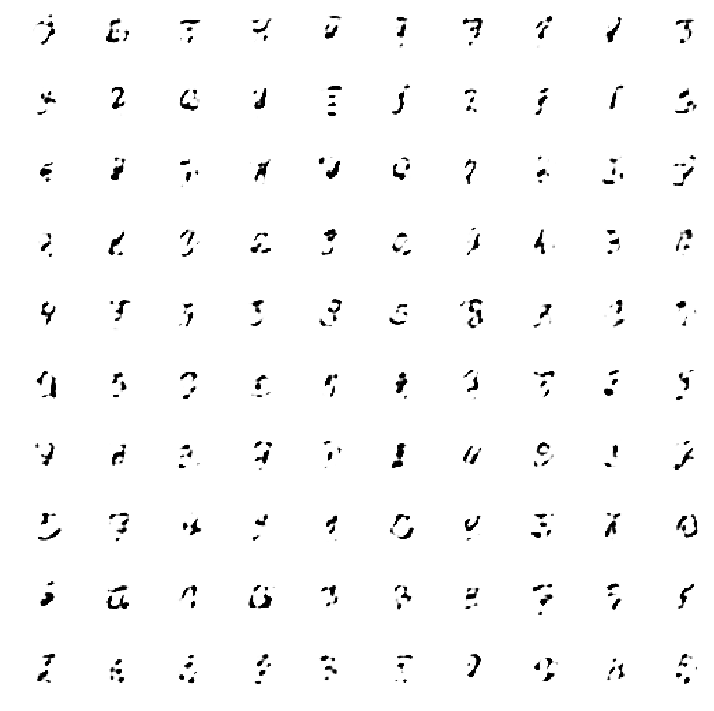

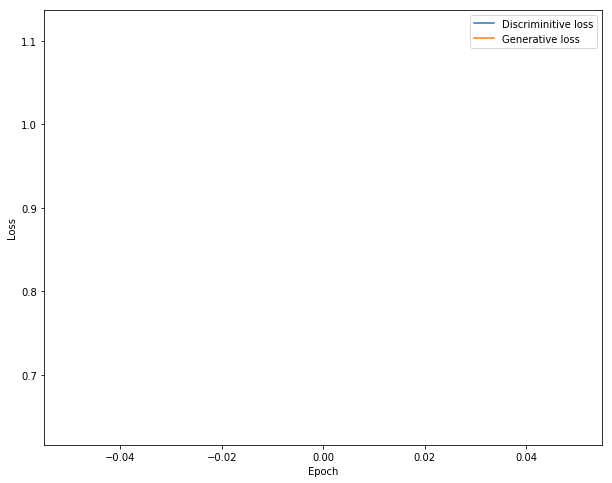

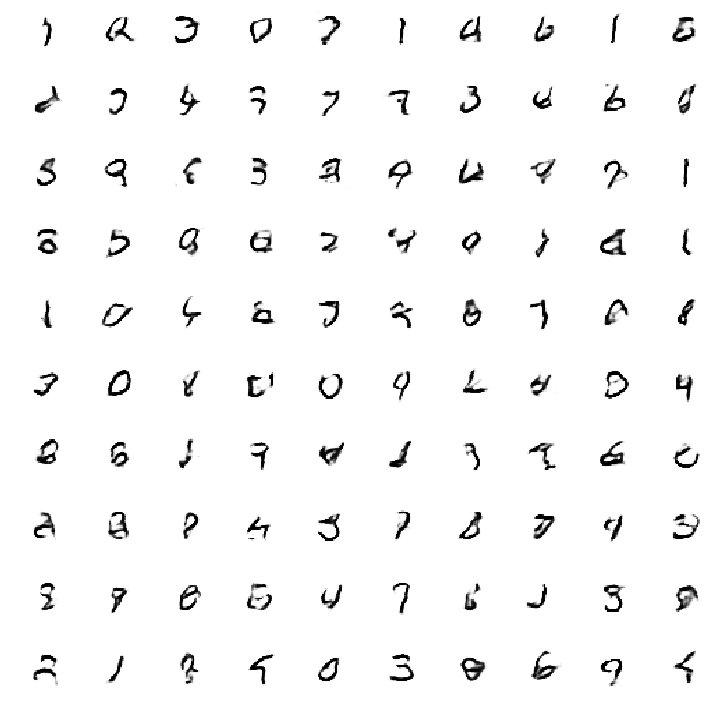

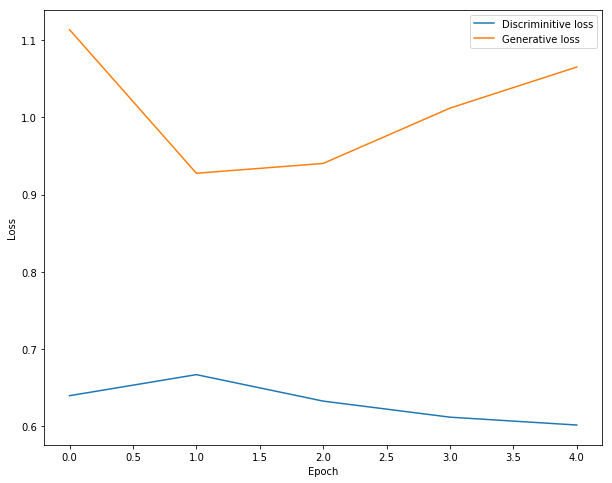

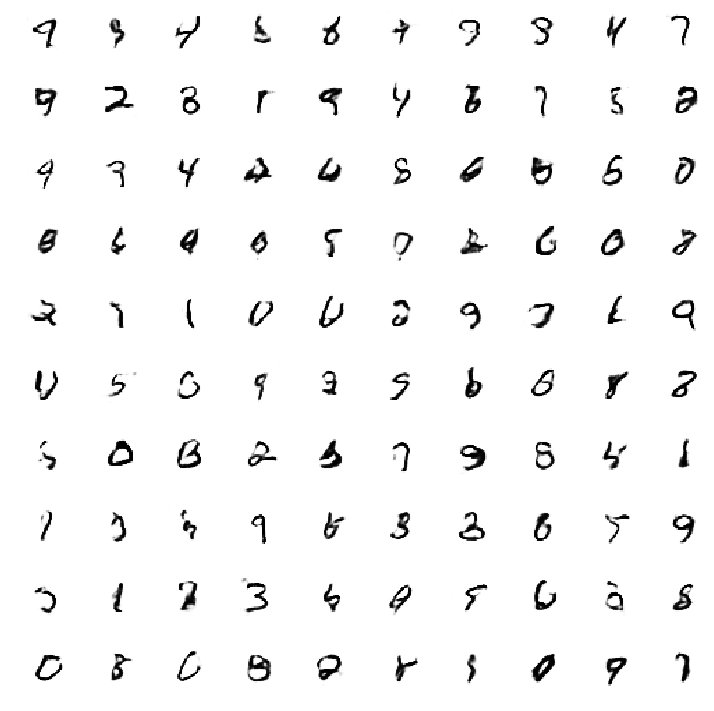

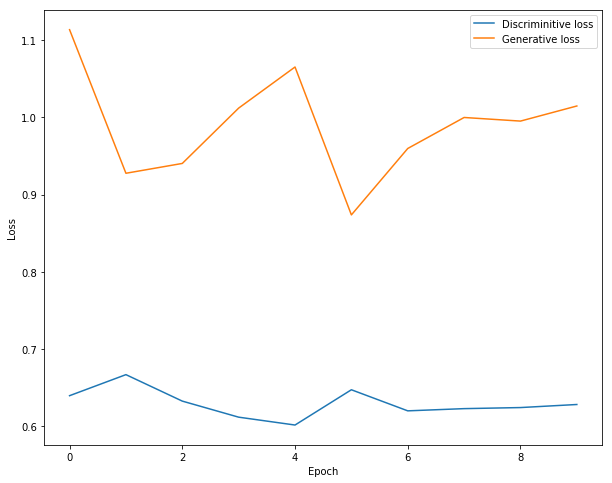

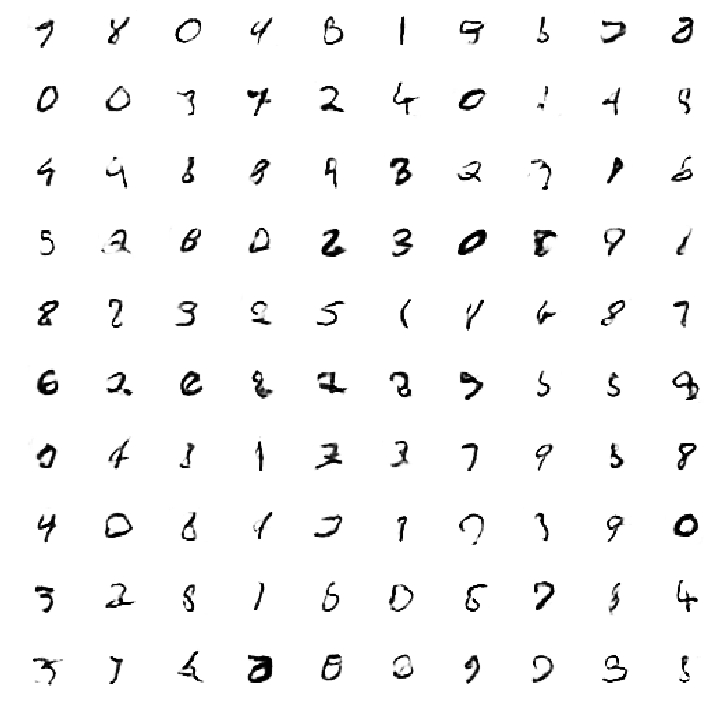

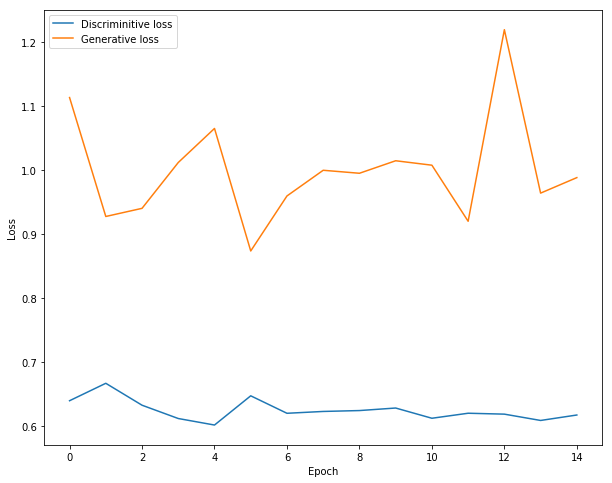

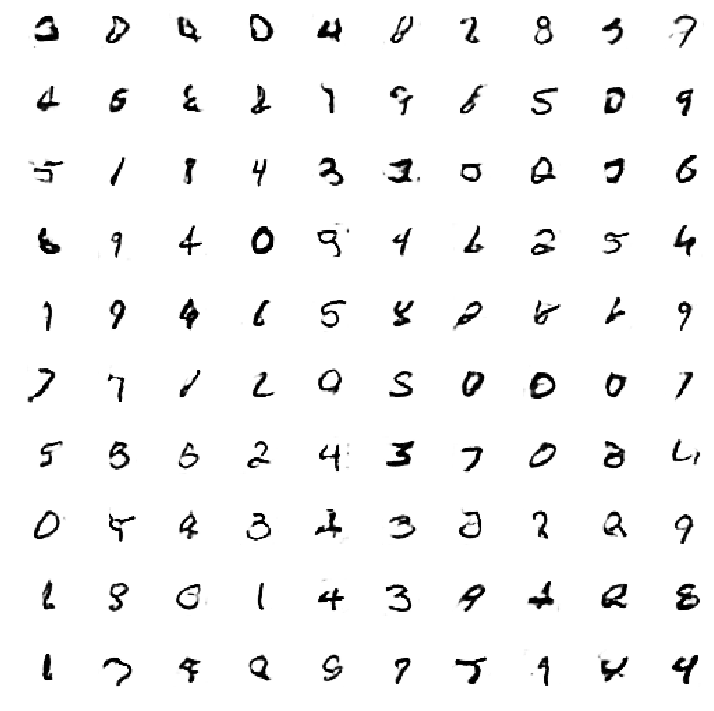

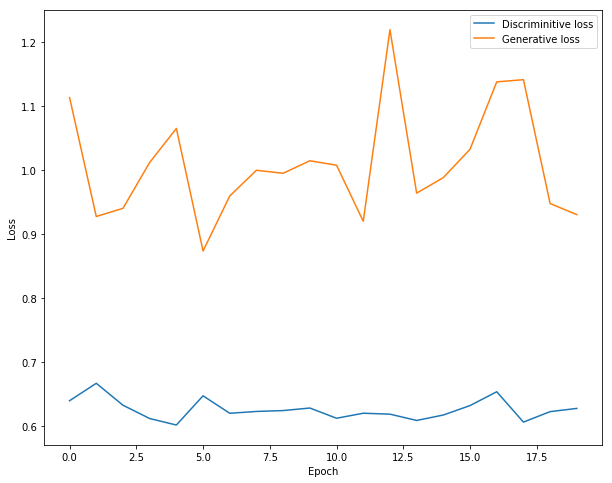

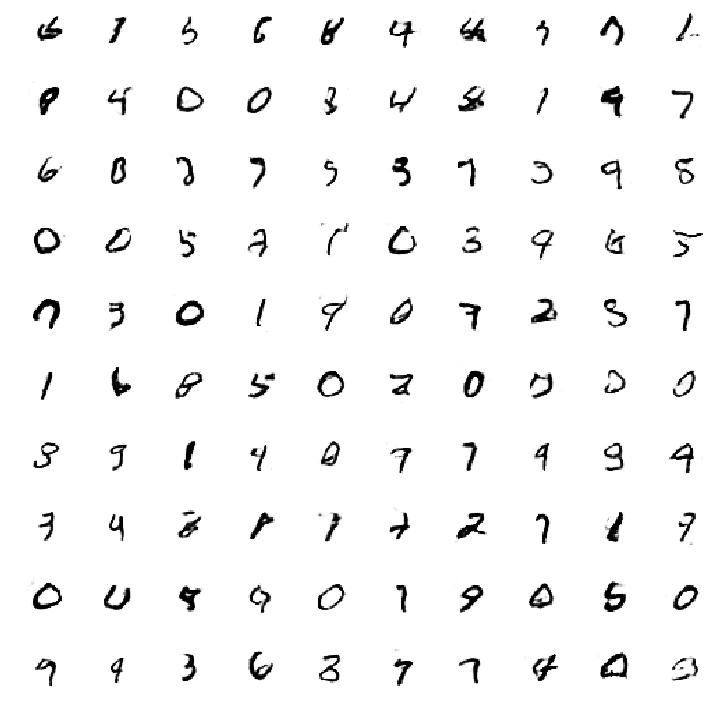

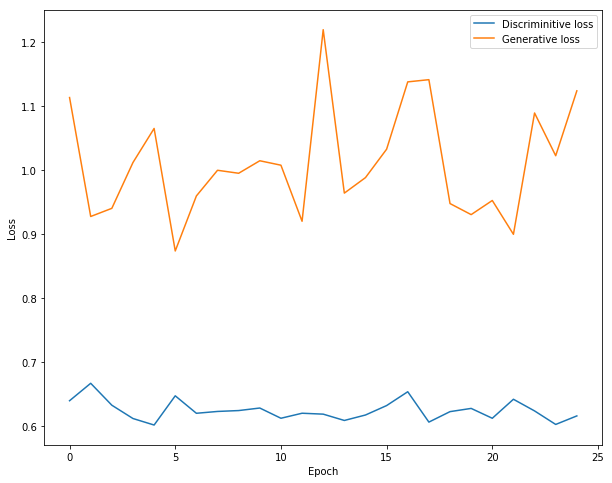

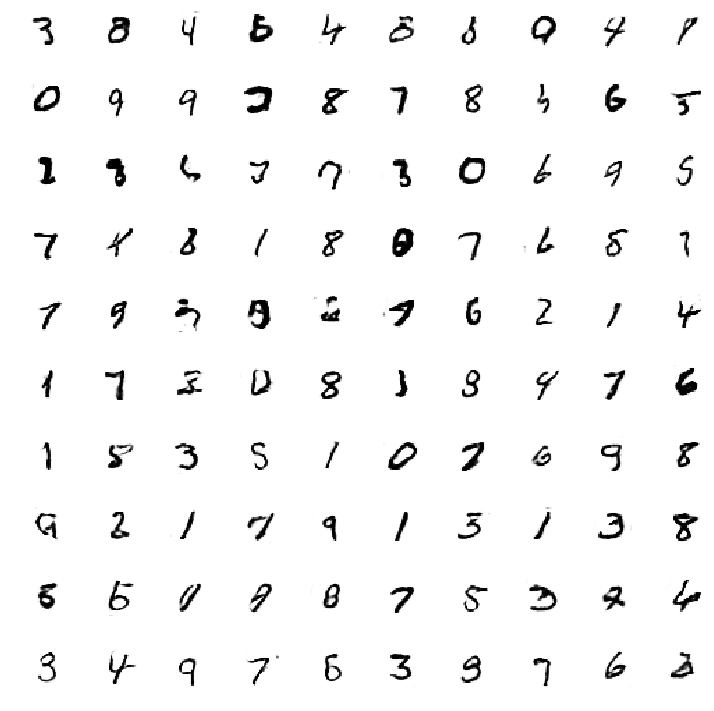

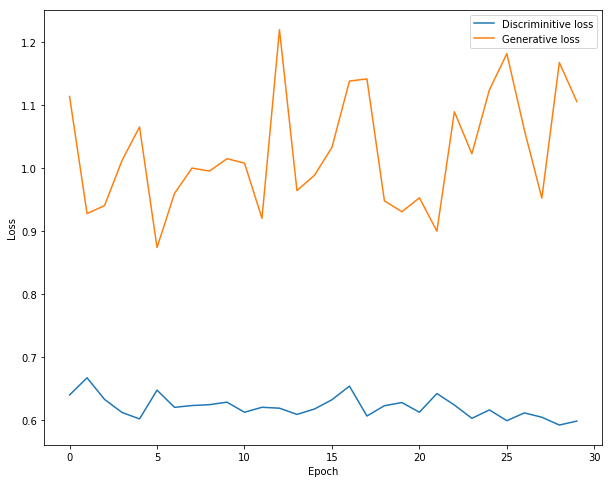

In [8]:
epochs = 30
batchSize = 128
batchCount = X_train.shape[0] / batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
        #randomly select images from Mnist data
        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 5 == 0:
        plotGeneratedImages(e)
        
        # Plot losses from every epoch
        plotLoss(e)
        #saveModels(e)



In [ ]:
>>>DONE<<<